# Triple collocation

Triple collocation is a method to estimate the unknown error of three timeseries with the same underlying geophysical variable [Stoffelen1998]. It is based on the following error model:

$$x = \alpha_x + \beta_x\Theta + \varepsilon_x$$
$$y = \alpha_y + \beta_y\Theta + \varepsilon_y$$
$$z = \alpha_z + \beta_z\Theta + \varepsilon_z$$

in which $\Theta$ is the true value of the geophysical variable e.g. soil moisture. $\alpha$ and $\beta$ are additive and multiplicative biases of the data and $\varepsilon$ is the zero mean random noise which we want to estimate.

Estimation of the triple collocation error $\varepsilon$ is commonly done using one of two approaches:

1. Scaling/calibrating the datasets to a reference dataset (removing $\alpha$ and $\beta$) and calculating the triple collocation error based on these datasets.
2. Estimation of the triple collocation error based on the covariances between the datasets. This also yields (linear) scaling parameters ($\beta$) which can be used if scaling of the datasets is desired.

The scaling approaches used in approach 1 are not ideal for e.g. data assimilation. Under the assumption that assimilated observations should have orthogonal errors, triple collocation based scaling parameters are ideal [Yilmaz2013].

Approach 2 is recommended for scaling if three datasets are available.

In this example we will show how `pytesmo` can be used to estimate random noise with three datasets using triple collocation.

We will demonstrate this with an example using synthetic data that follows the error model from above.

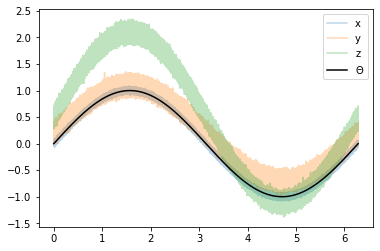

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# number of observations
n = 1000000
# x coordinates for initializing the sine curve
coord = np.linspace(0, 2*np.pi, n)
signal = np.sin(coord)

# error i.e. epsilon of the three synthetic time series
sig_err_x = 0.02
sig_err_y = 0.07
sig_err_z = 0.04
err_x = np.random.normal(0, sig_err_x, n)
err_y = np.random.normal(0, sig_err_y, n)
err_z = np.random.normal(0, sig_err_z, n)

# additive and multiplicative biases
# they are assumed to be zero for dataset x
alpha_y = 0.2
alpha_z = 0.5

beta_y = 0.9
beta_z = 1.6

x = signal + err_x
# here we assume errors that are already scaled
y = alpha_y + beta_y * (signal + err_y) 
z = alpha_z + beta_z * (signal + err_z)

plt.plot(coord, x, alpha=0.3, label='x')
plt.plot(coord, y, alpha=0.3, label='y')
plt.plot(coord, z, alpha=0.3, label='z')
plt.plot(coord, signal, 'k', label=r'$\Theta$')
plt.legend();

In approach 2 we can estimate the triple collocation errors, the scaling parameter $\beta$ and the signal to noise ratio directly from the covariances of the dataset. For a general overview and how Apporach 1 and 2 are related please see [Gruber2015].

Estimation of the error variances from the covariances of the datasets (e.g. $\sigma_{XY}$ for the covariance between $x$ and $y$) is done using the following formula:

$\sigma_{\varepsilon_x}^2 = \sigma_{X}^2 - \frac{\sigma_{XY}\sigma_{XZ}}{\sigma_{YZ}}$

$\sigma_{\varepsilon_y}^2 = \sigma_{Y}^2 - \frac{\sigma_{YX}\sigma_{YZ}}{\sigma_{XZ}}$

$\sigma_{\varepsilon_z}^2 = \sigma_{Z}^2 - \frac{\sigma_{ZY}\sigma_{ZX}}{\sigma_{YX}}$

$\beta$ can also be estimated from the covariances:

$\beta_x = 1 \quad \quad \quad \beta_y = \frac{\sigma_{XZ}}{\sigma_{YZ}} \quad \quad \quad \beta_z=\frac{\sigma_{XY}}{\sigma_{ZY}}$

The signal to noise ratio (SNR) is also calculated from the variances and covariances:

$\text{SNR}_X[dB] = -10\log\left(\frac{\sigma_{X}^2\sigma_{YZ}}{\sigma_{XY}\sigma_{XZ}}-1\right)$

$\text{SNR}_Y[dB] = -10\log\left(\frac{\sigma_{Y}^2\sigma_{XZ}}{\sigma_{YX}\sigma_{YZ}}-1\right)$

$\text{SNR}_Z[dB] = -10\log\left(\frac{\sigma_{Z}^2\sigma_{XY}}{\sigma_{ZX}\sigma_{ZY}}-1\right)$

It is given in dB to make it symmetric around zero. If the value is zero it means that the signal variance and the noise variance are equal. +3dB means that the signal variance is twice as high as the noise variance.

This apporach is implemented in `pytesmo.metrics.tcol_metrics`.

In [2]:
from pytesmo.metrics import tcol_metrics

snr, err, beta = tcol_metrics(x, y, z)
print(f"Error of x: {err[0]:.4f}, true: {sig_err_x:.4f}")       
print(f"Error of y: {err[1]:.4f}, true: {sig_err_y:.4f}")
print(f"Error of z: {err[2]:.4f}, true: {sig_err_z:.4f}")

Error of x: 0.0200, true: 0.0200
Error of y: 0.0701, true: 0.0700
Error of z: 0.0400, true: 0.0400


The estimation works very well in this example.

We can now also check if $\beta_y$ and $\beta_z$ were correctly estimated.

The function gives us the inverse values of $beta$. We can use these values directly to scale our datasets.

In [3]:
print("scaling parameter for y estimated: {:.2f}, true:{:.2f}".format(1/beta[1], beta_y))
print("scaling parameter for z estimated: {:.2f}, true:{:.2f}".format(1/beta[2], beta_z))

scaling parameter for y estimated: 0.90, true:0.90
scaling parameter for z estimated: 1.60, true:1.60


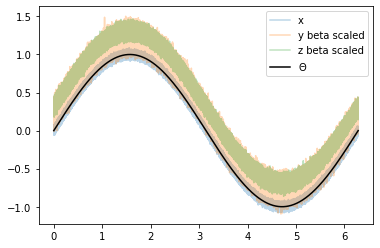

In [4]:
y_beta_scaled = y * beta[1]
z_beta_scaled = z * beta[2]
plt.plot(coord, x, alpha=0.3, label='x')
plt.plot(coord, y_beta_scaled, alpha=0.3, label='y beta scaled')
plt.plot(coord, z_beta_scaled, alpha=0.3, label='z beta scaled')
plt.plot(coord, signal, 'k', label=r'$\Theta$')
plt.legend();

The datasets still have different mean values i.e. different $\alpha$ values. These can be removed by subtracting the mean of the dataset.

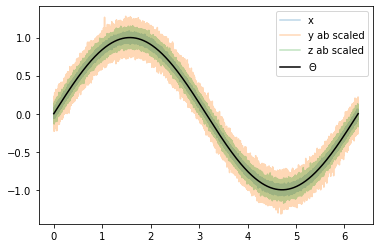

In [5]:
y_ab_scaled = y_beta_scaled - np.mean(y_beta_scaled)
z_ab_scaled = z_beta_scaled - np.mean(z_beta_scaled)
plt.plot(coord, x, alpha=0.3, label='x')
plt.plot(coord, y_ab_scaled, alpha=0.3, label='y ab scaled')
plt.plot(coord, z_ab_scaled, alpha=0.3, label='z ab scaled')
plt.plot(coord, signal, 'k', label=r'$\Theta$')
plt.legend();

This yields scaled/calibrated datasets using triple collocation based scaling which is ideal for e.g. data assimilation.

The SNR is nothing else than the fraction of the signal variance to the noise variance in dB

Let's first print the snr we got from `metrics.tcol_metrics`

In [6]:
print(snr)

[30.98653541 20.07942605 24.94787017]


Now let's calculate the SNR starting from the variance of the sine signal and the $\sigma$ values we used for our additive errors. 

In [7]:
[10*np.log10(np.var(signal)/(sig_err_x)**2),
10*np.log10(np.var(signal)/(sig_err_y)**2),
10*np.log10(np.var(signal)/(sig_err_z)**2)]

[30.969095787133575, 20.087734900128062, 24.94849587385395]

We can see that the estimated SNR and the "real" SNR of our artifical datasets are very similar.

## References

[Stoffelen1998]: - Stoffelen, A. (1998). Toward the true near-surface wind speed: error modeling
  and calibration using triple collocation. Journal of Geophysical Research:
  Oceans (1978--2012), 103(C4), 7755–7766.

[Yilmaz2013]: - Yilmaz, M. T., & Crow, W. T. (2013). The optimality of potential rescaling
  approaches in land data assimilation. Journal of Hydrometeorology, 14(2),
  650–660.
  
[Gruber2015]:- Gruber, A., Su, C., Zwieback, S., Crow, W., Dorigo, W., Wagner, W. (2015). Recent advances in (soil moisture) triple collocation analysis. International Journal of Applied Earth Observation and Geoinformation, in review